# Camera Calibration
Here we will read in 20 chessboard images for calibrating our camera.

In [20]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


CAL_IMAGES_DIR = './camera_cal/'
TEST_IMAGES_DIR = './test_images/'
X_DIM = 9
Y_DIM = 6


def get_images(dir):
    """Returns all the images in a directory as a list"""
    return [mpimg.imread(dir + image) for image in os.listdir(dir)]


def compute_cal_points(images, x_dim=X_DIM, y_dim=Y_DIM):
    """Returns a tuple that contains (object points, image points)"""
    objp = np.zeros((x_dim*y_dim, 3), np.float32)
    objp[:,:2] = np.mgrid[0:x_dim, 0:y_dim].T.reshape(-1,2)
    
    objpoints, imgpoints = [], []
    
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (x_dim, y_dim), None)
        
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    return (objpoints, imgpoints)


def undistort(image, objpoints, imgpoints):
    """Returns an undistorted image withthe given objpoints and imgpoints"""
    image_shape = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)
    
    return cv2.undistort(image, mtx, dist, None, mtx)


cal_images = get_images(CAL_IMAGES_DIR)
objpoints, imgpoints = compute_cal_points(cal_images)

Here we can see a distorted image and an undistorted image below it

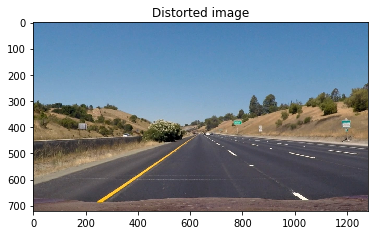

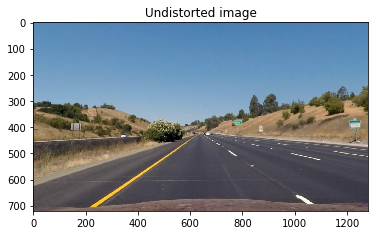

In [21]:
test_images = get_images(TEST_IMAGES_DIR)
undistorted_img = undistort(test_images[0], objpoints, imgpoints)
plt.title('Distorted image')
plt.imshow(test_images[0])
plt.show()
plt.title('Undistorted image')
plt.imshow(undistorted_img)
plt.show()

# Transform the image
Now we want to apply a perspective transform so we can view the road from a top down view

In [22]:
def distort_coeff(image_shape, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)
    return (mtx, dist)


def corners_unwarp(image, mtx, dist):
    """Performs a perspective transform on an undistorted image so we can view the road from above"""
    
    # Points were found on the Udacity Slack Channel by Chris Grill
    src = np.float32([[220, 719], [1220, 719], [750, 480], [550, 480]])
    dest = np.float32([[240, 719], [1040, 719], [1040, 300], [240, 300]])
    
    M = cv2.getPerspectiveTransform(src, dest)
    image_shape = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, image_shape, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dest, src)
    return warped, M, Minv

mtx, dist = distort_coeff(test_images[0].shape[::-1][1:], objpoints, imgpoints)
warped, M, Minv = corners_unwarp(undistorted_img, mtx, dist)

Here we have an undistorted image and its perspective transform below it.

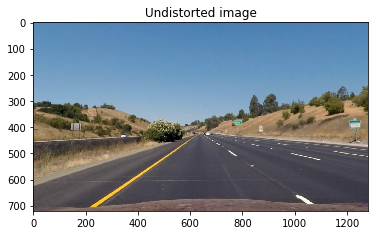

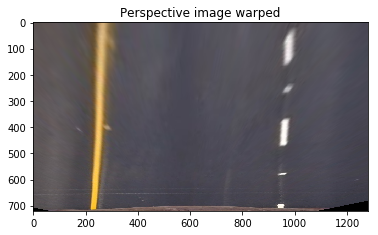

In [23]:
plt.title("Undistorted image")
plt.imshow(undistorted_img)
plt.show()

plt.title("Perspective image warped")
plt.imshow(warped)
plt.show()

# Creating a thresholded binary image
Here we will use the gradient, color transforms, and other methods to output the thresholded binary image.

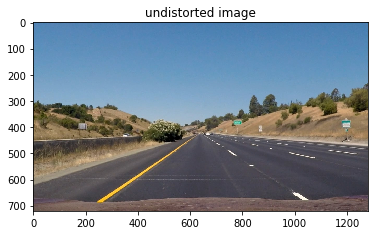

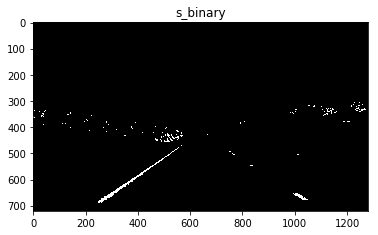

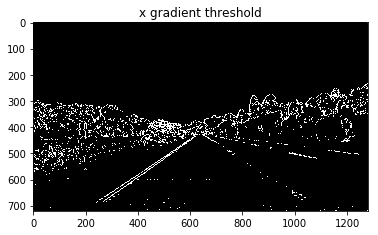

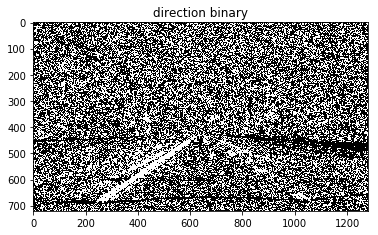

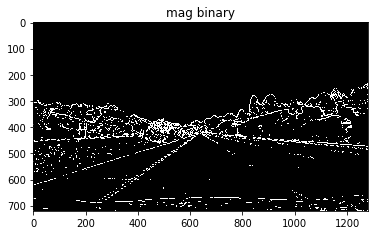

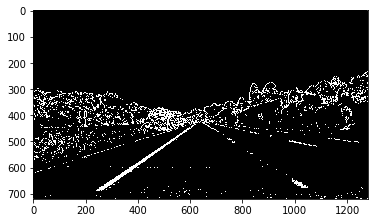

In [24]:
def grad(img, *, orient='x', sobel_kernel=3):
    """Compute the gradient across an axis"""
    if orient == 'x':
        orientation = (1, 0)
    elif orient == 'y':
        orientation = (0, 1)
    else:
        raise ValueError('{} is not a correct orientation'.format(orient))

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    grad = cv2.Sobel(gray, cv2.CV_64F, *orientation, ksize=sobel_kernel)
    return grad


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """Takes the absolute value, scales the gradient and applies a threshold"""
    sobel = grad(img, orient=orient, sobel_kernel=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return binary_out(scaled_sobel, thresh)


def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    """Returns the magnitude of the gradient in both x and y over a threshold"""
    sobel_x = grad(img, orient='x', sobel_kernel=sobel_kernel)
    sobel_y = grad(img, orient='y', sobel_kernel=sobel_kernel)
    
    grad_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    grad_mag_scaled = np.int8(grad_mag*255/(np.max(grad_mag)))
    return binary_out(grad_mag_scaled, mag_thresh)


def direction_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """Returns edges in a specific orientation"""
    sobel_x = grad(img, orient='x', sobel_kernel=sobel_kernel)
    sobel_y = grad(img, orient='y', sobel_kernel=sobel_kernel)
    
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    direction = np.arctan2(abs_sobel_y, abs_sobel_x)    
    return binary_out(direction, thresh)


def binary_out(data, thresh=(0, 255)):
    """Returns the binary thresholded image for a given threshold range"""
    binary_out = np.zeros_like(data)
    binary_out[(thresh[0] <= data) & (data <= thresh[1])] = 1

    return binary_out


def display_image(image, title, gray=False):
    plt.title(title)
    if gray:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()
    

def combine_thresholds(image, display=False):
    abs_binary = abs_sobel_thresh(image, orient='x', thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
    direction_binary = direction_thresh(image, sobel_kernel=15, thresh=(0.7, 1.3))
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = binary_out(s_channel, thresh=(170, 255))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) 
                    |(abs_binary == 1)
                    |((mag_binary == 1) & (direction_binary == 1))] = 1
    
    if display:
        display_image(image, "undistorted image")
        display_image(s_binary, "s_binary", gray=True)
        display_image(abs_binary, "x gradient threshold", gray=True)
        display_image(direction_binary, "direction binary", gray=True)
        display_image(mag_binary, "mag binary", gray=True)
    
    return combined_binary



image = test_images[0]
combined_thresholds = combine_thresholds(image, display=True)
plt.imshow(combined_thresholds, cmap='gray')
plt.show()

Here we perform the thresholding and perspective transform

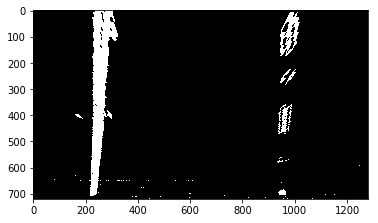

In [25]:
processed_img, M, Minv = corners_unwarp(combined_thresholds, mtx, dist)
plt.imshow(processed_img, cmap='gray')

# Establishing pipeline for image processing
Here we will create a function that will perform the following:
    - undistortion
    - binary thresholding
    - perspective transform

In [26]:
def pipeline(image):
    undistorted_img = undistort(image, objpoints, imgpoints)
    combined_binary = combine_grad_with_channel(undistorted_img)
    processed_img, M, Minv = corners_unwarp(combined_binary, mtx, dist)
    return processed_img, M, Minv

Let's visualize the pipeline for all the test images

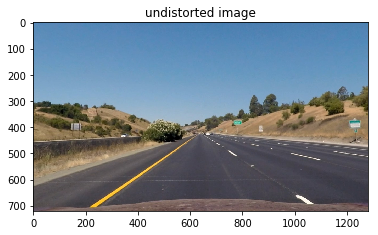

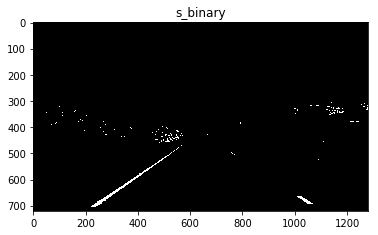

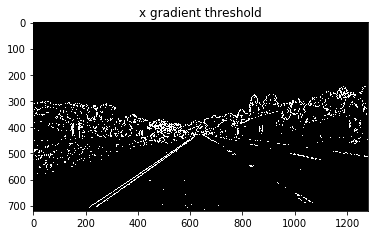

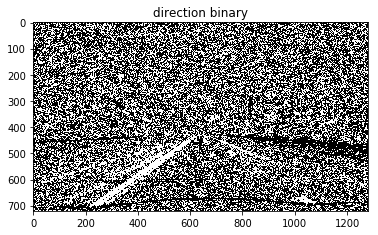

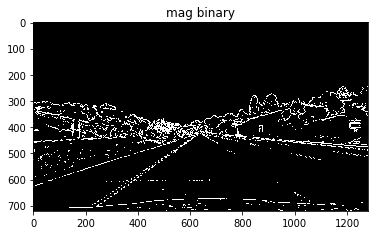

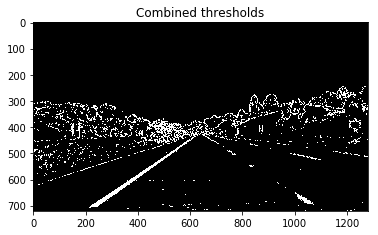

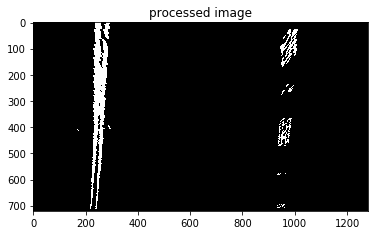

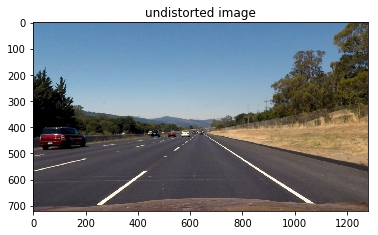

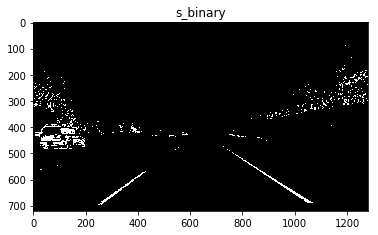

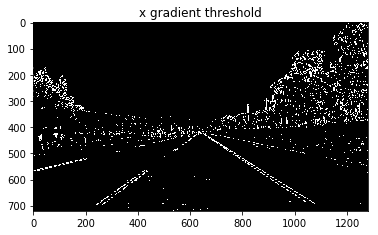

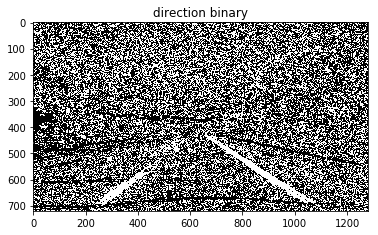

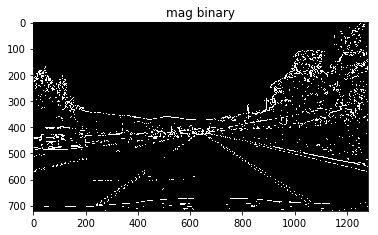

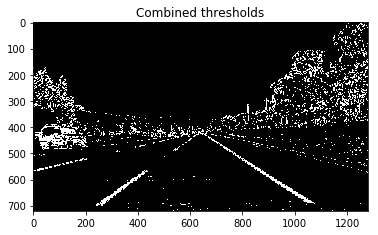

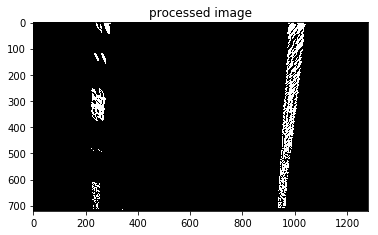

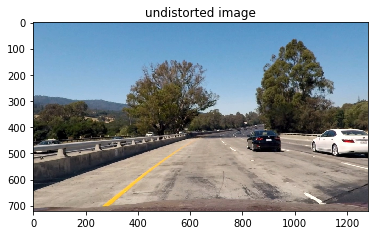

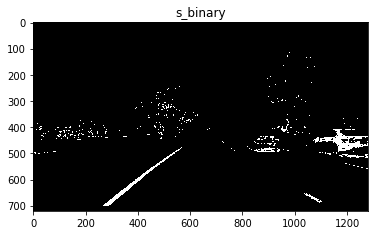

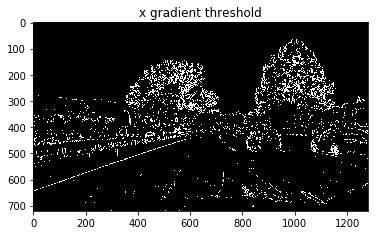

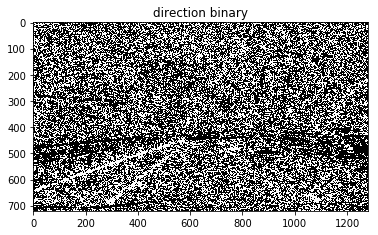

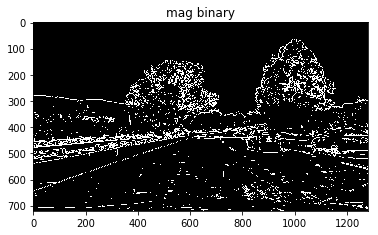

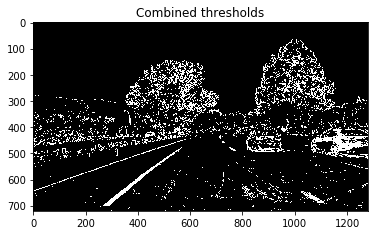

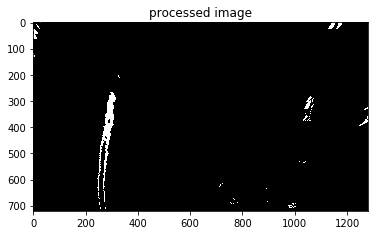

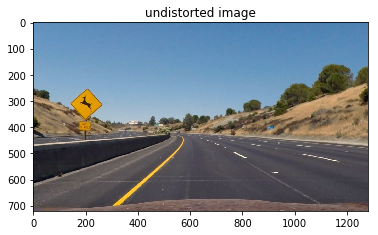

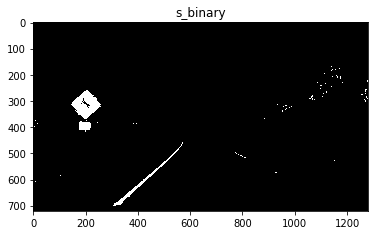

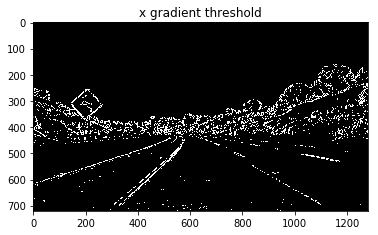

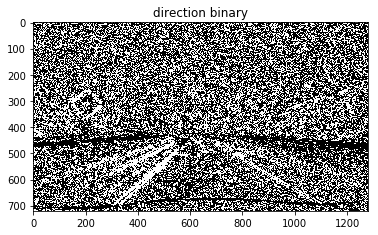

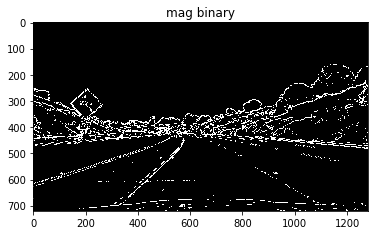

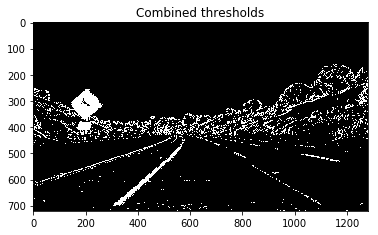

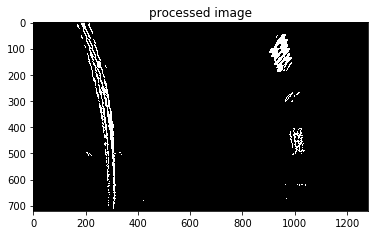

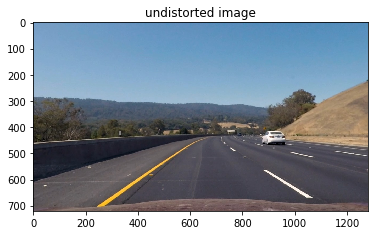

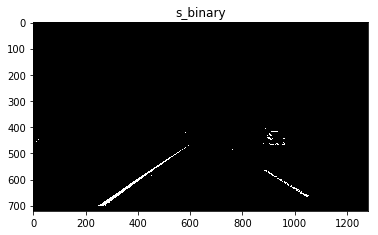

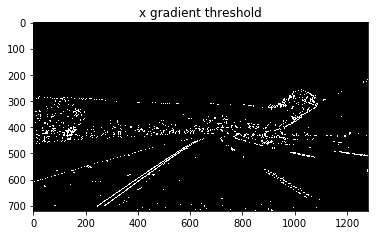

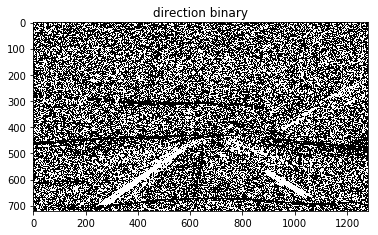

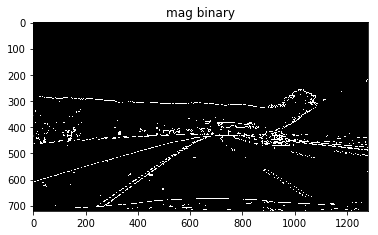

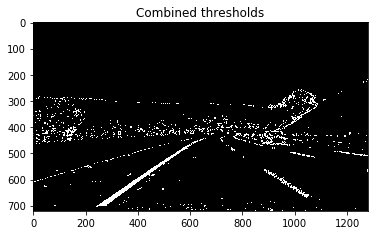

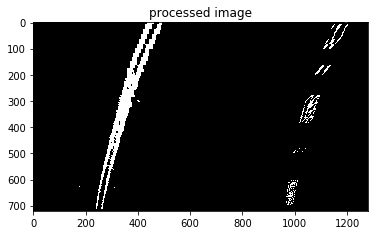

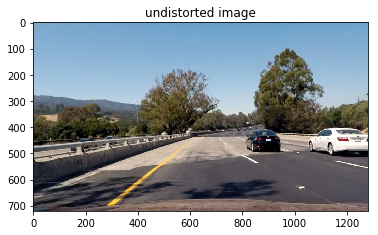

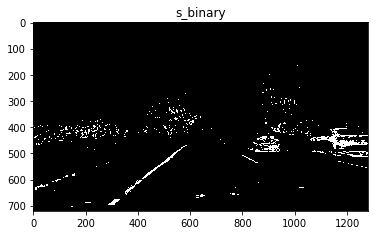

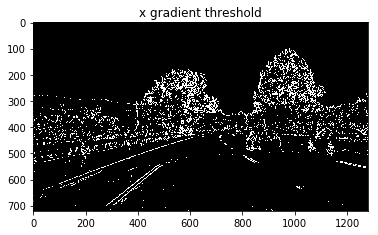

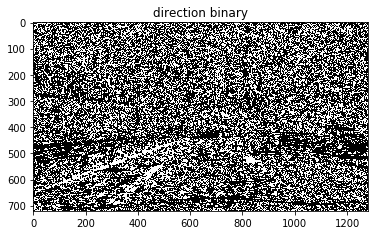

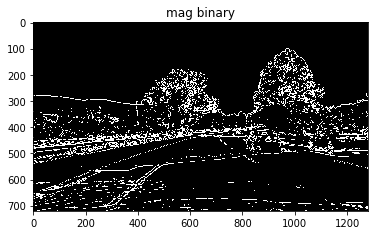

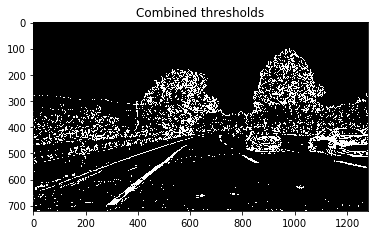

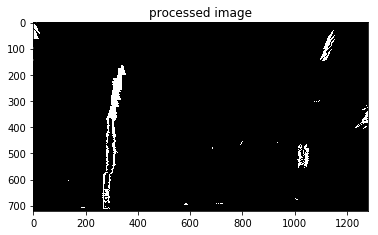

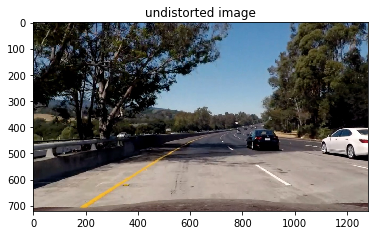

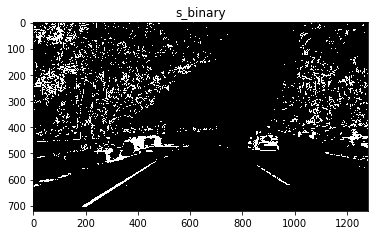

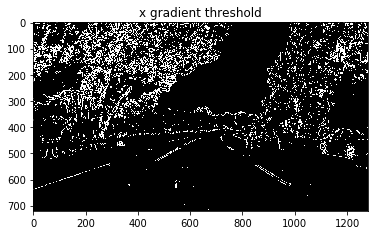

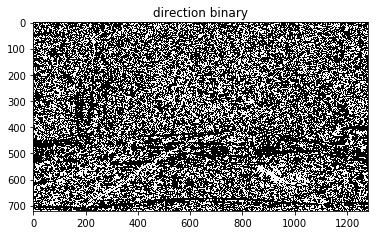

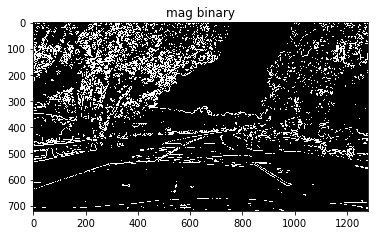

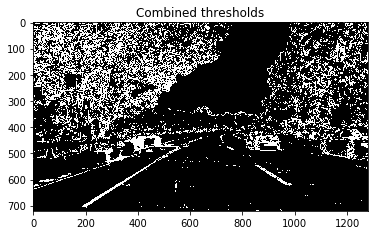

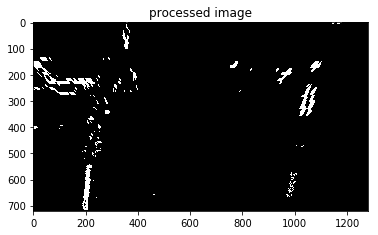

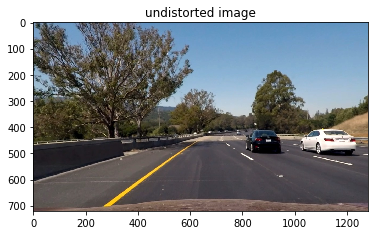

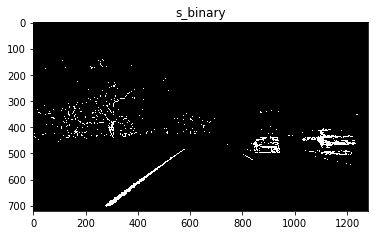

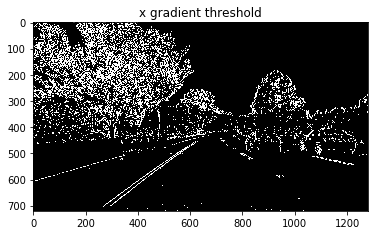

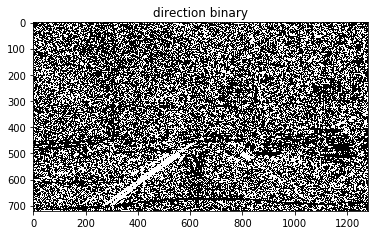

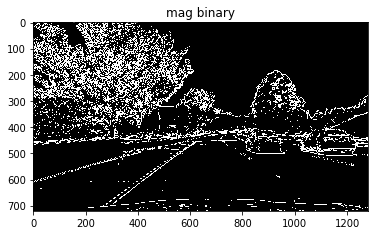

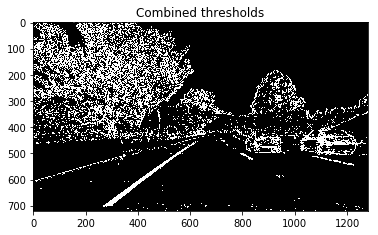

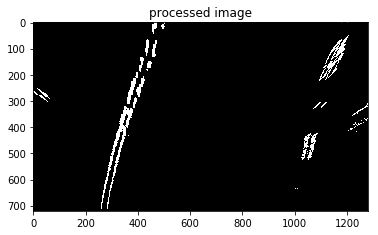

In [27]:
for image in test_images:
    # Normally we only need to call pipeline to process everything, but here
    # we will look at each step
    undistorted_img = undistort(image, objpoints, imgpoints)
    combined_binary = combine_thresholds(undistorted_img, display=True)
    display_image(combined_binary, "Combined thresholds", gray=True)
    
    processed_image, _, _ = pipeline(image)
    display_image(processed_image, "processed image", gray=True)

# Detecting the left and right lanes
Here I will be using the histogram method to determine the left and right lane lines

By plotting the fully processed image, we can see that there are two major peaks.
The one on the left should be the left lane, and the one on the right should be the right lane.

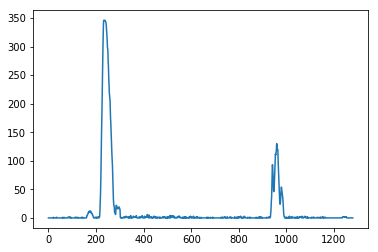

In [28]:
histogram = np.sum(processed_img[processed_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

Now we will implement a sliding window and fit a polynomial to the line

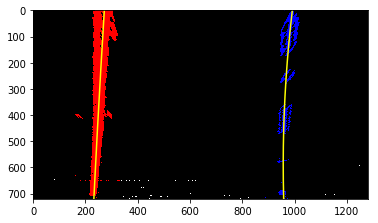

In [29]:
def fit_lines(img, histogram):
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    NUM_WINDOWS = 9
    window_height = np.int(img.shape[0]/NUM_WINDOWS)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    #out_img = np.dstack((img, img, img))*255
    for window in range(NUM_WINDOWS):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds


def display_curves(img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    out_img = np.dstack((img, img, img))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    
left_fit, right_fit, left_lane_inds, right_lane_inds = fit_lines(processed_img, histogram)
display_curves(processed_img, left_fit, right_fit, left_lane_inds, right_lane_inds)

Now that you have a previous image, it is easier to find the next line's pixels

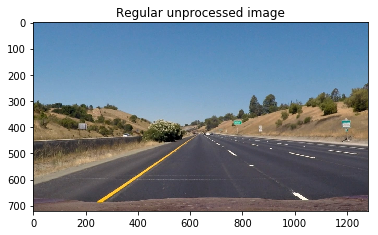

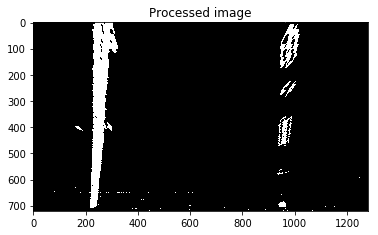

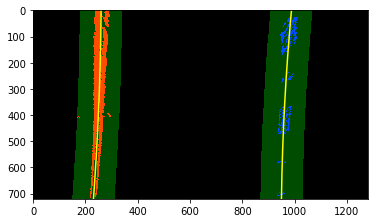

In [30]:
image = test_images[0]
processed_image, _, Minv = pipeline(image)
display_image(image, "Regular unprocessed image")
display_image(processed_img, "Processed image", gray=True)


def fit_lines_from_prev(img, left_fit, right_fit):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds
    
    
def visualize_fit(img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    
left_fit, right_fit, left_lane_inds, right_lane_inds = fit_lines_from_prev(processed_image, left_fit, right_fit)
visualize_fit(processed_image, left_fit, right_fit, left_lane_inds, right_lane_inds)

# Drawing the curves back into the image

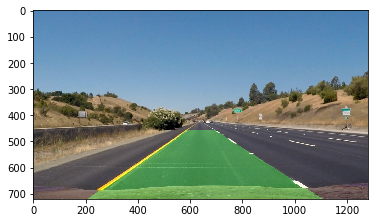

In [31]:
def draw_curves_into_image(image, Minv, processed_image, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(processed_image).astype(np.uint8)
    color_warp = np.dstack((processed_image, processed_image, processed_image))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, processed_image.shape[0]-1, processed_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result
    
image_with_curves = draw_curves_into_image(image, Minv, processed_image, left_fit, right_fit)
plt.imshow(image_with_curves)

# Calculating left and right curvatures

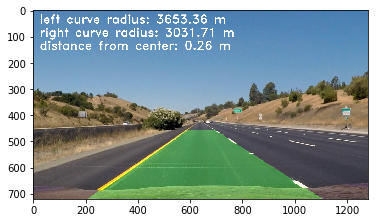

In [32]:
def calculate_curvatures(img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad


def distance_from_lane_center(img, left_fit, right_fit):
    """Computes the x values of the left and right line
    and returns the distance from the car's center to the lane center
    """
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y = img.shape[0]
    center = img.shape[1]/2
    left_fit_x = left_fit[0]*y**2  + left_fit[1]*y + left_fit[2]
    right_fit_x = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    lane_center = (left_fit_x + right_fit_x) / 2
    dist_from_center = (center - lane_center) * xm_per_pix
    return dist_from_center
    
    
def draw_lane_info(img, curvatures, dist_from_center):
    img_with_info = np.copy(img)
    font = cv2.FONT_HERSHEY_DUPLEX

    text = 'left curve radius: {:04.2f} m'.format(curvatures[0])
    cv2.putText(img_with_info, text, (25, 50), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    
    text = 'right curve radius: {:04.2f} m'.format(curvatures[1])
    cv2.putText(img_with_info, text, (25, 100), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    
    text = 'distance from center: {:04.2f} m'.format(dist_from_center)
    cv2.putText(img_with_info, text, (25, 150), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    return img_with_info
    
    
left_curverad, right_curverad = calculate_curvatures(processed_image, left_fit, right_fit, left_lane_inds, right_lane_inds)
dist_from_center = distance_from_lane_center(image_with_curves, left_fit, right_fit)
image_with_info = draw_lane_info(image_with_curves, (left_curverad, right_curverad), dist_from_center)
plt.imshow(image_with_info)
plt.show()

# Here we create a line class to keep track of previous fits
This allows us to smooth out the curves and display something if we do not detect any lines

In [33]:
from collections import deque

class Line:
    def __init__(self, num_fits):
        self._num_fits = num_fits
        self.detected = False
        self.fits = deque()
        self.best_fit = None
        
    def add_fit(self, fit):
        if fit is None:
            return
        if len(self.fits) == self._num_fits:
            self.fits.popleft()
            
        self.fits.append(fit)
        self.best_fit = self.average_fits()
        
    def average_fits(self):
        A_sum = B_sum = C_sum = 0
        
        for fit in self.fits:
            A_sum += fit[0]
            B_sum += fit[1]
            C_sum += fit[2]
            
            n = len(self.fits)
        return [A_sum/n, B_sum/n, C_sum/n]
        

# Process the video and detect lane lines

In [34]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_fit = None
right_fit = None

window_size = 10
left_line = Line(window_size)
right_line = Line(window_size)


def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    global left_fit
    global right_fit
    
    processed_image, M, Minv = pipeline(image)

    if left_fit is None or right_fit is None:
        histogram = np.sum(processed_image[processed_image.shape[0]//2:,:], axis=0)
        left_fit, right_fit, left_lane_inds, right_lane_inds = fit_lines(processed_image, histogram)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = fit_lines_from_prev(processed_image, left_fit, right_fit)
    
    left_line.add_fit(left_fit)
    right_line.add_fit(right_fit)
    
    dist_from_center = distance_from_lane_center(image, left_line.best_fit, right_line.best_fit)
    left_curverad, right_curverad = calculate_curvatures(processed_image, left_line.best_fit, right_line.best_fit,
                                                         left_lane_inds, right_lane_inds)
    
    image = draw_lane_info(image, (left_curverad, right_curverad), dist_from_center)
    result = draw_curves_into_image(image, Minv, processed_image, left_line.best_fit, right_line.best_fit)

    return result


video = './project_video.mp4'
video_output = './project_video_output.mp4'
video_input = VideoFileClip(video)
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
processed_video = video_input.fl_image(process_image)#.subclip(35, 36) #NOTE: this function expects color images!!
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [18:12<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

Wall time: 18min 13s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))